In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = Path("/content/drive/MyDrive/1. 428_project/Group_1/Group_1/train")
test_path = Path("/content/drive/MyDrive/1. 428_project/Group_1/Group_1/test")

In [ ]:
def load_images(folder_path):
    images = [] # x
    labels = [] # y
    class_dict = {}

    for sub_folder_path in folder_path.iterdir():
        if sub_folder_path.is_dir():
            class_name = sub_folder_path.name
            class_images = []

            for img_path in sub_folder_path.iterdir():
                image = load_img(img_path)
                image_array = img_to_array(image) # ing to array

                images.append(image_array)
                labels.append(class_name)
                class_images.append(image_array)

            class_dict[class_name] = np.array(class_images)

    unique_labels = np.unique(labels)

    return [[np.array(images), np.array(labels)], class_dict, unique_labels]


# **1.1) What is the size of your dataset? Is there a separate batch for train, test, and validation, or do you need to do it manually?**

In [ ]:
# loading the train and test data as numpy array and giving label to the train data

X_train_org, Y_train_org = load_images(train_path)[0]
X_test, Y_test = load_images(test_path)[0]


In [ ]:
X_train_org.shape,  Y_train_org.shape

((2155, 64, 64, 3), (2155,))

In [ ]:
X_test.shape, Y_test.shape

((255, 64, 64, 3), (255,))

In [ ]:
print(f"There are {X_train_org.shape[0] + X_test.shape[0]} samples in the Dataset.")

There are 2410 samples in the Dataset.


* There is seperate branch for train and test data but there is no vaidation data. So, we have to make the validation data manually.

#  **1.2)What are the different classes in your dataset?**

In [ ]:
labels = load_images(train_path)[2]
labels

array(['bear', 'boa-constrictor', 'bullfrog', 'golden-retriever',
       'goldfish'], dtype='<U16')

# **2. What is the distribution of your dataset? the number of samples per class? Show it using a plot. Is the distribution balanced or unbalanced?**

## Ploting the number of samples per class:

In [ ]:
for key, values in load_images(train_path)[1].items():
    num_values = len(values)
    print(f"'{key}' class has {num_values} images.")

'golden-retriever' class has 500 images.
'bullfrog' class has 250 images.
'goldfish' class has 500 images.
'boa-constrictor' class has 400 images.
'bear' class has 505 images.


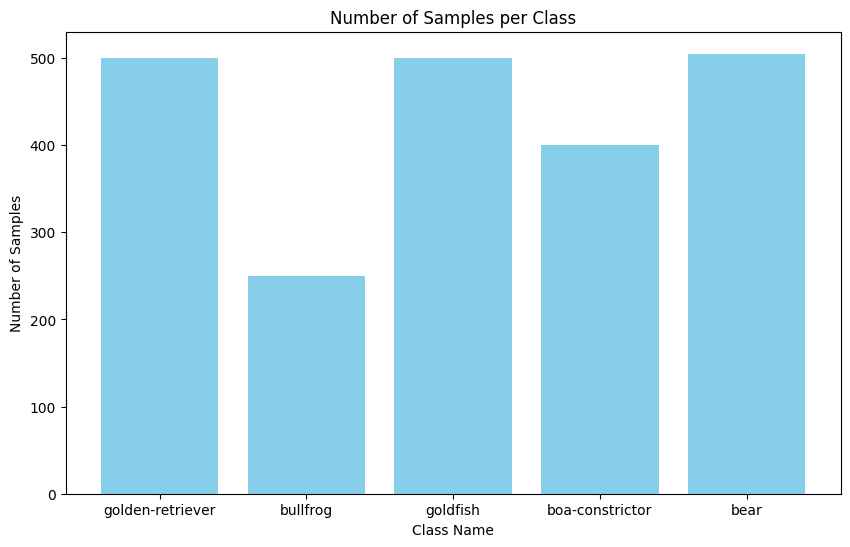

In [ ]:
import matplotlib.pyplot as plt

def plot_samples_per_class(class_dict):
    class_names = list(class_dict.keys())
    num_samples = [len(class_dict[class_name]) for class_name in class_names]

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, num_samples, color='skyblue')
    plt.xlabel('Class Name')
    plt.ylabel('Number of Samples')
    plt.title('Number of Samples per Class')
    plt.show()

plot_samples_per_class(load_images(train_path)[1])


# 3. Which technique are you going to use to tackle your unbalanced dataset and why?

**Data Augmentation:**
   - Generate additional training samples by applying transformations (rotation, scaling, flipping, etc.) to existing samples. This is particularly useful when you have limited data for some classes.

# Part 4 & 5

Evaluation function

In [ ]:
def evaluate_model(y_true, y_pred, labels):
    # Calculating accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Computing the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Initializing arrays to hold the per-class metrics
    sensitivities = []
    specificities = []
    ppvs = []
    npvs = []

    # Calculate metrics for each class
    for class_index in range(len(labels)):
        tp = cm[class_index, class_index]
        fn = np.sum(cm[class_index, :]) - tp
        fp = np.sum(cm[:, class_index]) - tp
        tn = np.sum(cm) - (fp + fn + tp)

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
        npv = tn / (tn + fn) if (tn + fn) != 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        ppvs.append(ppv)
        npvs.append(npv)

    # Calculating averages
    sensitivity = np.mean(sensitivities)
    specificity = np.mean(specificities)
    ppv = np.mean(ppvs)
    npv = np.mean(npvs)

    # Generating classification report
    class_report = classification_report(y_true, y_pred, target_names=labels)


    return([accuracy, sensitivity, specificity, ppv, npv, cm, class_report])


## Logistic Regression

In [ ]:
# seperating some data from train for validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_org, Y_train_org, test_size=0.2, random_state=428)

In [ ]:
X_train.shape, X_validation.shape

((1724, 64, 64, 3), (431, 64, 64, 3))

In [ ]:
# flattening the each data

X_train_org_flatten = X_train_org.reshape(X_train_org.shape[0], -1)
X_train_org_flatten = preprocessing.minmax_scale(X_train_org_flatten)

X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_train_flatten = preprocessing.minmax_scale(X_train_flatten)

X_validation_flatten = X_validation.reshape(X_validation.shape[0], -1)
X_validation_flatten = preprocessing.minmax_scale(X_validation_flatten)

X_test_flatten = X_test.reshape(X_test.shape[0], -1)
X_test_flatten = preprocessing.minmax_scale(X_test_flatten)

In [ ]:
X_train.shape, X_train_flatten.shape

((1724, 64, 64, 3), (1724, 12288))

In [ ]:
# Training logistic regressing model

LR = LogisticRegression(C=1, fit_intercept=True, solver='lbfgs', max_iter=300)
LR.fit(X_train_flatten, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=300)

In [ ]:
# Evaluating the model in train set & validation set

validation_prediction = LR.predict(X_validation_flatten)
validation_accuracy = accuracy_score(Y_validation, validation_prediction)

print(f"Validation Set Accuracy: {validation_accuracy * 100:.2f}%")

Validation Set Accuracy: 50.35%


In [ ]:
# Predictions
y_pred_train = LR.predict(X_train_flatten)
y_pred_test = LR.predict(X_test_flatten)

# Evaluating on Train data
train_eval_LR = evaluate_model(Y_train, y_pred_train, labels)
print("## Training Set Metrics:")
print()
print(f"Accuracy: {train_eval_LR[0] * 100:.2f}%\n"
      f"Sensitivity: {train_eval_LR[1]}\n"
      f"Specificity: {train_eval_LR[2]}\n"
      f"PPV: {train_eval_LR[3]}\n"
      f"NPV: {train_eval_LR[4]}\n"
      f"Confusion Matrix:\n{train_eval_LR[5]}\n"
      f"Classification Report:\n{train_eval_LR[6]}")

print()
print()

# Evaluating on Test data
test_eval_LR = evaluate_model(Y_test, y_pred_test, labels)
print("\n## Test Set Metrics:")
print()
print(f"Accuracy: {test_eval_LR[0] * 100:.2f}%\n"
      f"Sensitivity: {test_eval_LR[1]}\n"
      f"Specificity: {test_eval_LR[2]}\n"
      f"PPV: {test_eval_LR[3]}\n"
      f"NPV: {test_eval_LR[4]}\n"
      f"Confusion Matrix:\n{test_eval_LR[5]}\n"
      f"Classification Report:\n{test_eval_LR[6]}")

## Training Set Metrics:

Accuracy: 100.00%
Sensitivity: 1.0
Specificity: 1.0
PPV: 1.0
NPV: 1.0
Confusion Matrix:
[[419   0   0   0   0]
 [  0 324   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 395   0]
 [  0   0   0   0 386]]
Classification Report:
                  precision    recall  f1-score   support

            bear       1.00      1.00      1.00       419
 boa-constrictor       1.00      1.00      1.00       324
        bullfrog       1.00      1.00      1.00       200
golden-retriever       1.00      1.00      1.00       395
        goldfish       1.00      1.00      1.00       386

        accuracy                           1.00      1724
       macro avg       1.00      1.00      1.00      1724
    weighted avg       1.00      1.00      1.00      1724




## Test Set Metrics:

Accuracy: 38.82%
Sensitivity: 0.3825454545454545
Specificity: 0.84709756097561
PPV: 0.3552659717877109
NPV: 0.8498072304189443
Confusion Matrix:
[[27  5  3 12  3]
 [ 8 11  6 14 11]
 [15 14  4 14  3

## Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt

In [ ]:
X_train_org.shape

(2155, 64, 64, 3)

In [ ]:
X_train_org_flatten.shape

(2155, 12288)

In [ ]:
number_of_classes = len(labels)
number_of_classes

5

In [ ]:
labels

array(['bear', 'boa-constrictor', 'bullfrog', 'golden-retriever',
       'goldfish'], dtype='<U16')

In [ ]:
# to be able to encode we must have numarical data

labels_dict = {label: idx for idx, label in enumerate(labels)}

print(labels_dict)

{'bear': 0, 'boa-constrictor': 1, 'bullfrog': 2, 'golden-retriever': 3, 'goldfish': 4}


In [ ]:
def convert_labels_to_numbers(labels, labels_dict):
  return [labels_dict[label] for label in labels]

In [ ]:
Y_train_org_in_numbers = convert_labels_to_numbers(Y_train_org, labels_dict)
Y_test_in_numbers = convert_labels_to_numbers(Y_test, labels_dict)
Y_validation_in_numbers = convert_labels_to_numbers(Y_validation, labels_dict)

print(Y_train_org[-1])
print(Y_train_org_in_numbers[-1])

# Y_train = original_labels --> ['golden-retriever', 'bear', 'boa-constrictor', 'bullfrog', 'goldfish']
# Y_train_in_numbers = numbers --> [0,1,2,3,4]
# Y_train_NN = encoded

bear
0


In [ ]:
Y_train_org

array(['golden-retriever', 'golden-retriever', 'golden-retriever', ...,
       'bear', 'bear', 'bear'], dtype='<U16')

In [ ]:
#Y_train_org_in_numbers

In [ ]:
print("shape of Y_train_org =", Y_train_org.shape)
print("shape of Y_test =", Y_test.shape)
print()

Y_train_org_NN = to_categorical(Y_train_org_in_numbers, num_classes = number_of_classes)
Y_test_NN = to_categorical(Y_test_in_numbers, num_classes = number_of_classes)
Y_validation_NN = to_categorical(Y_validation_in_numbers, num_classes = number_of_classes)

print("shape of Y_train_org_NN =", Y_train_org_NN.shape)
print("shape of Y_test_NN =", Y_test_NN.shape)

shape of Y_train_org = (2155,)
shape of Y_test = (255,)

shape of Y_train_org_NN = (2155, 5)
shape of Y_test_NN = (255, 5)


In [ ]:
Y_train_org_NN[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# Model Building

NN = Sequential()
NN.add( Input(shape = (12288,)) ) # input layer
NN.add( Dense(4000, activation='sigmoid') ) #hidden layer 1
NN.add( Dense(1000, activation='sigmoid') ) #hidden layer 2   ## activation sigmoid
NN.add( Dense(50, activation='sigmoid') ) #hidden layer 3
NN.add( Dense(number_of_classes, activation='softmax') ) # output layer, activation softmax

In [ ]:
NN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

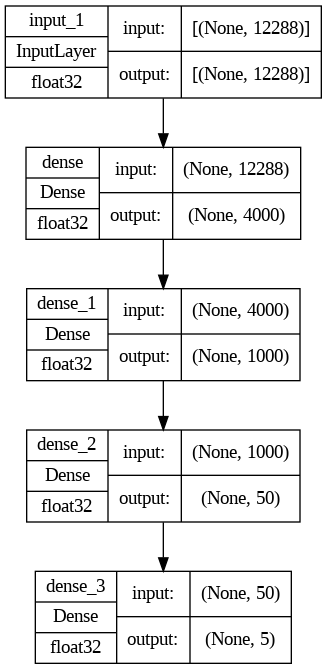

In [ ]:
plot_model(NN, show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
# saving the best weights

EPOCHS = 100
checkpoint_filepath = '/content/drive/MyDrive/1. 428_project/model_checkpoint/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

NN.fit(X_train_org_flatten, Y_train_org_NN, validation_data=(X_test_flatten, Y_test_NN),  verbose=1, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

NN.load_weights(checkpoint_filepath)

Epoch 1/100
68/68 [==============================] - 10s 66ms/step - loss: 1.6295 - accuracy: 0.2320 - val_loss: 1.6833 - val_accuracy: 0.1961
Epoch 2/100
68/68 [==============================] - 1s 20ms/step - loss: 1.5862 - accuracy: 0.2367 - val_loss: 1.6597 - val_accuracy: 0.1961
Epoch 3/100
68/68 [==============================] - 1s 19ms/step - loss: 1.5841 - accuracy: 0.2176 - val_loss: 1.6452 - val_accuracy: 0.1961
Epoch 4/100
68/68 [==============================] - 1s 17ms/step - loss: 1.5834 - accuracy: 0.2348 - val_loss: 1.6444 - val_accuracy: 0.1961
Epoch 5/100
68/68 [==============================] - 1s 17ms/step - loss: 1.5824 - accuracy: 0.2441 - val_loss: 1.6296 - val_accuracy: 0.1961
Epoch 6/100
68/68 [==============================] - 4s 59ms/step - loss: 1.5793 - accuracy: 0.2348 - val_loss: 1.6255 - val_accuracy: 0.2902
Epoch 7/100
68/68 [==============================] - 1s 18ms/step - loss: 1.5720 - accuracy: 0.2696 - val_loss: 1.6111 - val_accuracy: 0.1961
Epoch

In [ ]:
def map_predictions_to_strings(predictions, label_list):
    mapped_labels = [label_list[np.argmax(elem)] for elem in predictions]
    return mapped_labels

In [ ]:
labels

array(['bear', 'boa-constrictor', 'bullfrog', 'golden-retriever',
       'goldfish'], dtype='<U16')

In [ ]:
map_predictions_to_strings([[0.2, 0.07, 0.7, 0.0, 0.01],[0.8, 0.1, 0.0, 0.1, 0.01]], labels)

['bullfrog', 'bear']

In [ ]:
# Predictions
Y_pred_train_org_NN = NN.predict(X_train_org_flatten)
Y_pred_test_NN = NN.predict(X_test_flatten)

# mapping back to original form
Y_pred_train_org_mapped = map_predictions_to_strings(Y_pred_train_org_NN, labels)
Y_pred_test_mapped = map_predictions_to_strings(Y_pred_test_NN, labels)


# Evaluating on Train data
train_eval_NN = evaluate_model(Y_train_org, Y_pred_train_org_mapped, labels)
print("## Training Set Metrics in NN:")
print()
print(f"Accuracy: {train_eval_NN[0] * 100:.2f}%\n"
      f"Sensitivity: {train_eval_NN[1]}\n"
      f"Specificity: {train_eval_NN[2]}\n"
      f"PPV: {train_eval_NN[3]}\n"
      f"NPV: {train_eval_NN[4]}\n"
      f"Confusion Matrix:\n{train_eval_NN[5]}\n"
      f"Classification Report:\n{train_eval_NN[6]}")

print()
print()

# Evaluating on Test data
test_eval_NN = evaluate_model(Y_test, Y_pred_test_mapped, labels)
print("\n## Test Set Metrics in NN:")
print()
print(f"Accuracy: {test_eval_NN[0] * 100:.2f}%\n"
      f"Sensitivity: {test_eval_NN[1]}\n"
      f"Specificity: {test_eval_NN[2]}\n"
      f"PPV: {test_eval_NN[3]}\n"
      f"NPV: {test_eval_NN[4]}\n"
      f"Confusion Matrix:\n{test_eval_NN[5]}\n"
      f"Classification Report:\n{test_eval_NN[6]}")

8/8 [==============================] - 0s 3ms/step
## Training Set Metrics in NN:

Accuracy: 48.45%
Sensitivity: 0.41622970297029704
Specificity: 0.8655380390002747
PPV: 0.32970118077844424
NPV: 0.8725826766010776
Confusion Matrix:
[[346   0   0 158   1]
 [186   0   0 206   8]
 [153   0   0  93   4]
 [171   0   0 296  33]
 [ 42   0   0  56 402]]
Classification Report:
                  precision    recall  f1-score   support

            bear       0.39      0.69      0.49       505
 boa-constrictor       0.00      0.00      0.00       400
        bullfrog       0.00      0.00      0.00       250
golden-retriever       0.37      0.59      0.45       500
        goldfish       0.90      0.80      0.85       500

        accuracy                           0.48      2155
       macro avg       0.33      0.42      0.36      2155
    weighted avg       0.38      0.48      0.42      2155




## Test Set Metrics in NN:

Accuracy: 40.78%
Sensitivity: 0.40290909090909094
Specificity: 0.85224390

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
Y_pred_test_NN[:5]

array([[0.17233506, 0.18839961, 0.09472828, 0.31461126, 0.22992586],
       [0.00169174, 0.00427311, 0.00150016, 0.02529845, 0.9672365 ],
       [0.26438284, 0.23316713, 0.13011374, 0.28801095, 0.0843253 ],
       [0.29123023, 0.23981829, 0.13875133, 0.27036625, 0.05983391],
       [0.29122996, 0.23981825, 0.13875122, 0.2703664 , 0.05983413]],
      dtype=float32)

In [ ]:
Y_pred_test_mapped[:5]

['golden-retriever', 'goldfish', 'golden-retriever', 'bear', 'bear']

## Comparison between Logistic Regression & Neural Network

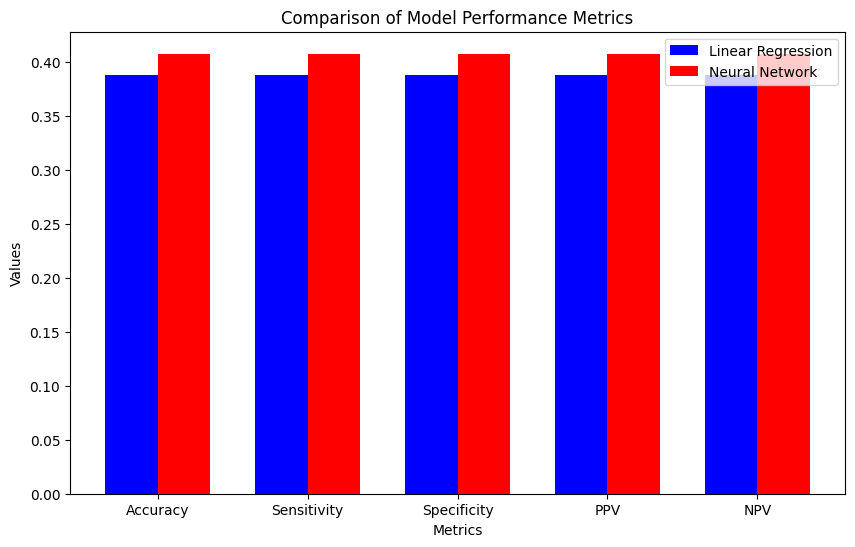

In [ ]:
def compare_models_performance(lr_metrics, nn_metrics):
    metrics_labels = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
    num_metrics = len(metrics_labels)

    lr_values = np.array(lr_metrics).T
    nn_values = np.array(nn_metrics).T

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Set positions for bar groups
    index = np.arange(num_metrics)

    # Plot bars for Linear Regression
    bar1 = ax.bar(index, lr_values[0], bar_width, label='Linear Regression', color='b')

    # Plot bars for Neural Network
    bar2 = ax.bar(index + bar_width, nn_values[0], bar_width, label='Neural Network', color='r')


    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Model Performance Metrics')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics_labels)
    ax.legend()


    plt.show()

compare_models_performance(test_eval_LR[:5], test_eval_NN[:5])
